# Causal Inference Example
## Monkeys, Leaves and Wind

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pytensor.tensor as pt

/var/folders/7h/tdfv8d5d6d79_0583_jhq_pm0000gn/T/ipykernel_31411/3361760345.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## W -> L <- M
Specify a generative model for wind. Wind comes from an exponential distribution, and our overvation of leaves comes from a boolean function with a link to wind.

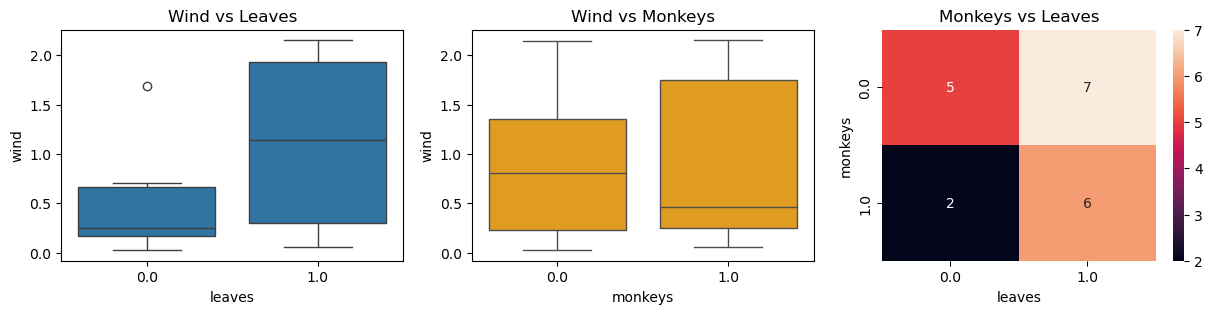

In [2]:
np.random.seed(seed=233423)

################# generate data #################
n = 20
# wind is normally distributed
W = 1 * stats.expon(0, 1).rvs(n)
# random monkeys
M = stats.bernoulli(0.4).rvs(n)
# model coefficients
a = -1
b = 1
c = 1
# link function
p = special.expit(a + b*W + c*M)
# boolean for leaves moving
L = stats.bernoulli(p).rvs(n)

# make dataframe
data = pd.DataFrame([L, M, W]).T
data.columns = ['leaves', 'monkeys', 'wind']
###################################################v

################# make box plots #################
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
# wind vs leaves
sns.boxplot(data=data, x='leaves', y='wind', ax=ax[0])
# wind vs monkeys
sns.boxplot(data=data, x='monkeys', y='wind', ax=ax[1], color='orange')
# monkeys vs leaves
sns.heatmap(pd.crosstab(data['monkeys'], data['leaves']), annot=True, ax=ax[2])

ax[0].set_title('Wind vs Leaves')
ax[1].set_title('Wind vs Monkeys')
ax[2].set_title('Monkeys vs Leaves')
###################################################

plt.show()

Here is the data:

In [3]:
data

,leaves,monkeys,wind
0,1.0,0.0,2.051926
1,1.0,0.0,2.140262
2,1.0,0.0,1.290943
3,0.0,0.0,0.158498
4,0.0,0.0,0.024421
5,1.0,1.0,2.152942
6,1.0,0.0,0.896959
7,0.0,0.0,0.708715
8,1.0,0.0,0.370386
9,0.0,1.0,1.689694


In [4]:
data.describe()

,leaves,monkeys,wind
count,20.00000,20.000000,20.000000
mean,0.65000,0.400000,0.898104
std,0.48936,0.502625,0.773176
min,0.00000,0.000000,0.024421
25%,0.00000,0.000000,0.230933
50%,1.00000,0.000000,0.668902
75%,1.00000,1.000000,1.573531
max,1.00000,1.000000,2.152942


Monkeys are correlated with leaves but not with wind (i.e., monkeys shake the leaves independent of whether or not the wind is blowing). Wind is correlated with leaves.

In [5]:
data.corr()

,leaves,monkeys,wind
leaves,1.000000,0.171184,0.368133
monkeys,0.171184,1.000000,0.003501
wind,0.368133,0.003501,1.000000


## L -> W
Are leaves driving the generation of wind? Specify incorrect causal model: L -> W

In [350]:
with pm.Model() as model:
    # specify prior distribution on leaves
    p = pm.Beta('beta', alpha=3, beta=3)
    L = pm.Bernoulli('leaves', p, observed=data.leaves)

    # specify prior for linear model
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 1)

    # linear model for expected wind
    u = pm.math.exp(a + b*L)
    # sample wind from exponential
    W = pm.Exponential('wind', u, observed=data.wind) 

    idata = pm.sample(1000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


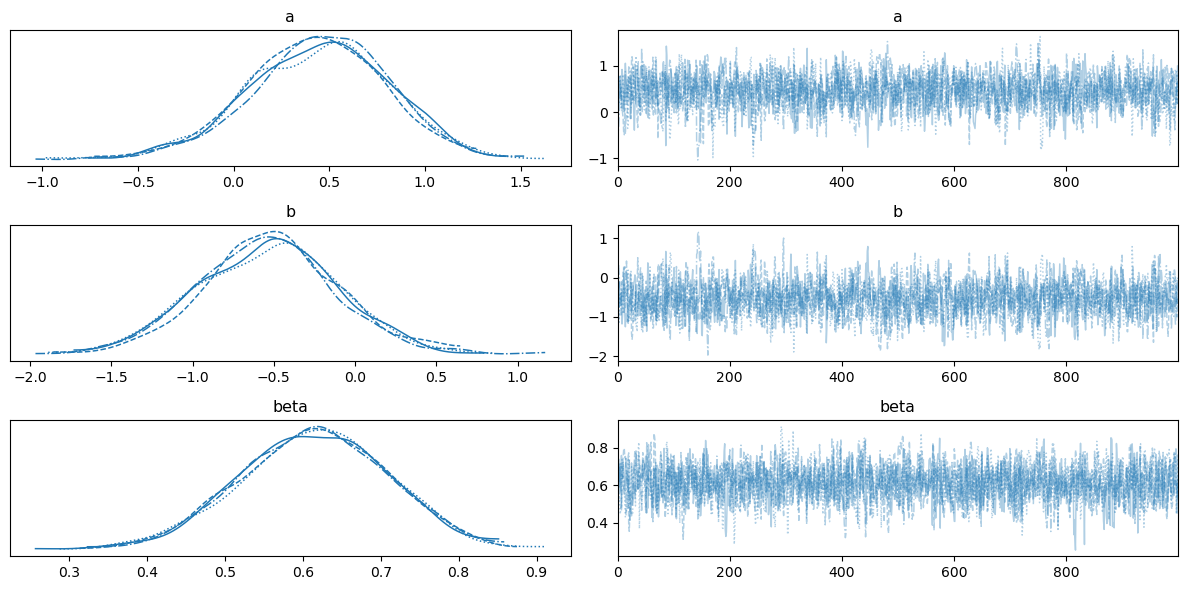

In [351]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [352]:
az.summary(idata).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.44,0.37,-0.21,1.16,0.01,0.01,1519.0,1499.0,1.0
b,-0.53,0.43,-1.33,0.29,0.01,0.01,1559.0,1982.0,1.0
beta,0.61,0.10,0.44,0.79,0.00,0.00,1929.0,1706.0,1.0


It looks like leaves increase wind on average by 11.6%. Now we have a business strategy: shake the trees!

In [353]:
a = idata.posterior.a.to_numpy().flatten().mean()
b = idata.posterior.b.to_numpy().flatten().mean()

u = data.wind.mean()
print('Avg. wind:', u.round(2))
x = 1/np.exp(a + b) - 1/np.exp(a)
print("Increase in wind with leaves:", '+' + str(x.round(2)))
print("Pct. increase in wind with leaves:", str((100 * x / u).round(1)) + '%')

Avg. wind: 0.9
Increase in wind with leaves: +0.45
Pct. increase in wind with leaves: 50.4%


Probability the leaves positively impact wind: 0.895


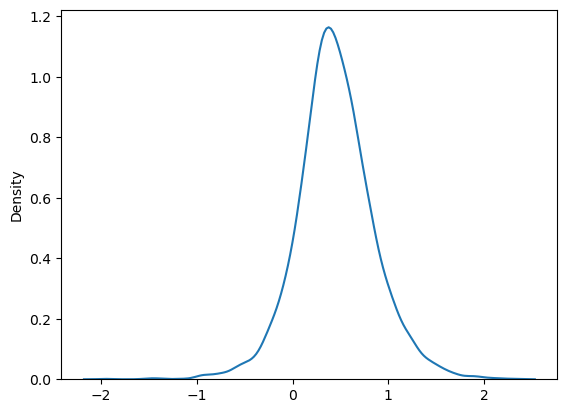

In [355]:
b = idata.posterior.b.to_numpy().flatten()
a = idata.posterior.a.to_numpy().flatten()

impact = 1 / np.exp(a + b) - 1 / np.exp(a)

print("Probability the leaves positively impact wind:", sum(impact > 0) / len(impact))
sns.kdeplot(impact)
plt.show()

In [287]:
# sample from posterior
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=101)

Sampling: [leaves, wind]


/Users/marialentini/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/marialentini/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


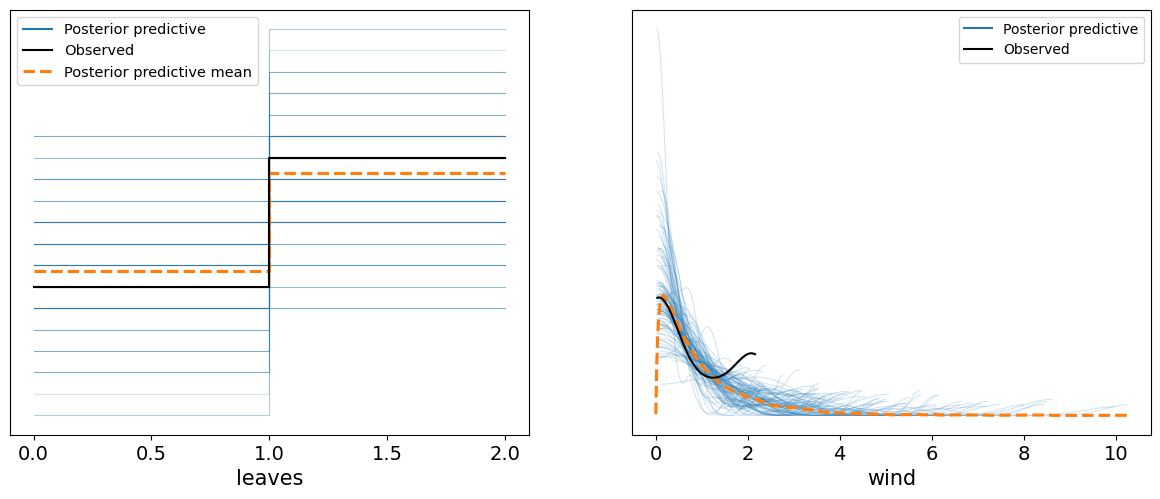

In [288]:
az.plot_ppc(idata, num_pp_samples=100)
plt.show()

## M -> L -> W
Now, we include monkeys in the model and assume: M -> L -> W via a two-stage regression:

In [51]:
# https://juanitorduz.github.io/iv_pymc/

n = data.shape[0]
with pm.Model() as model:

    # monkeys generate leaves
    a = pm.Normal('a', 0, 2)
    b = pm.Normal('b', 0, 2)
    c = pm.Normal('c', 0, 2)
    d = pm.Normal('d', 0, 2)

    # draw leaves from logit, fit to observations
    logit_pl = a + b*M
    leaves = pm.Bernoulli("leaves", logit_p=logit_pl, observed=L)

    # wind is >=0, mean = 1 / lambda 
    inv_mu_w = pm.math.exp(c + d*(a + b*M))
    wind = pm.Exponential("wind", inv_mu_w, observed=W)

    idata = pm.sample(1000, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


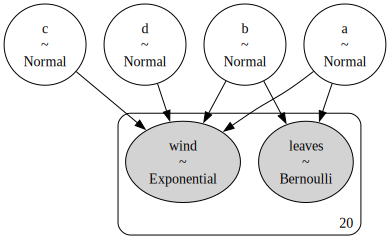

In [52]:
pm.model_to_graphviz(model=model)

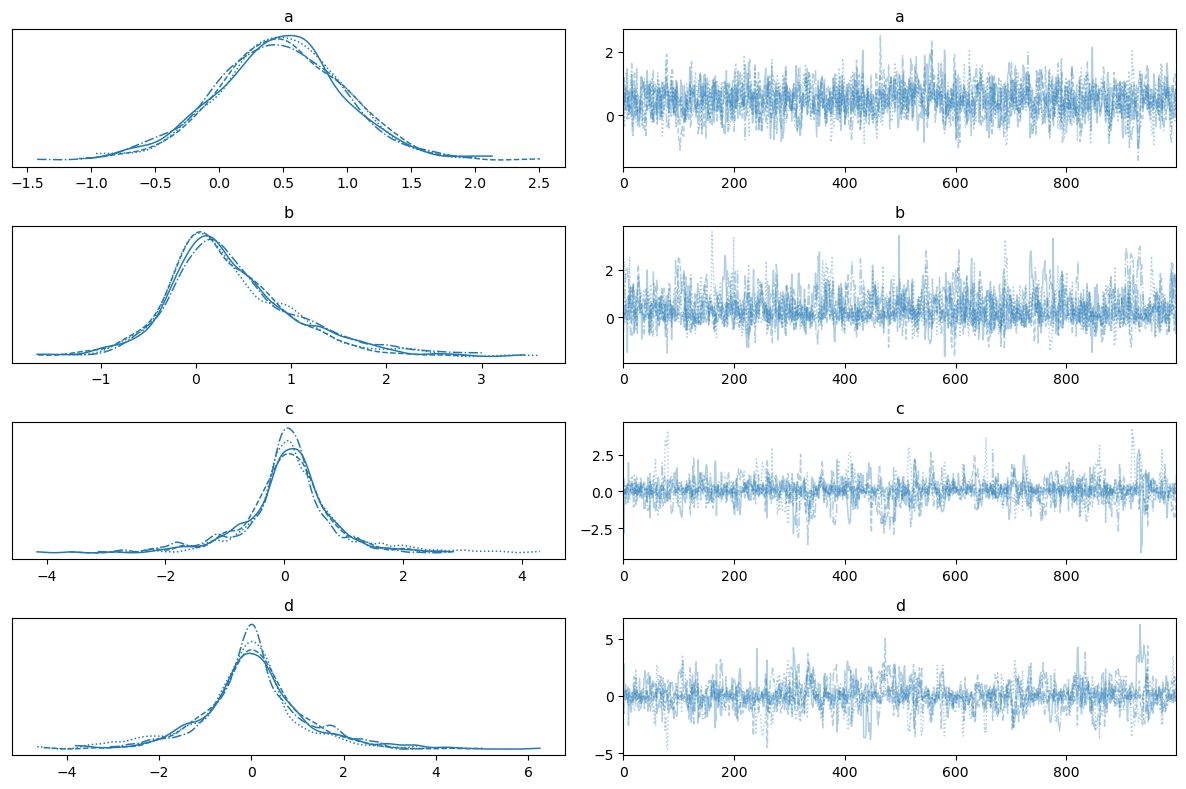

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.48,0.50,-0.48,1.40,0.02,0.01,1114.0,1481.0,1.00
b,0.37,0.67,-0.81,1.70,0.02,0.02,1087.0,893.0,1.00
c,0.08,0.76,-1.42,1.71,0.03,0.02,752.0,803.0,1.01
d,0.01,1.10,-2.27,2.15,0.04,0.03,651.0,823.0,1.01


In [53]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()

az.summary(idata).round(2)

Sampling: [leaves, wind]


/Users/marialentini/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/marialentini/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


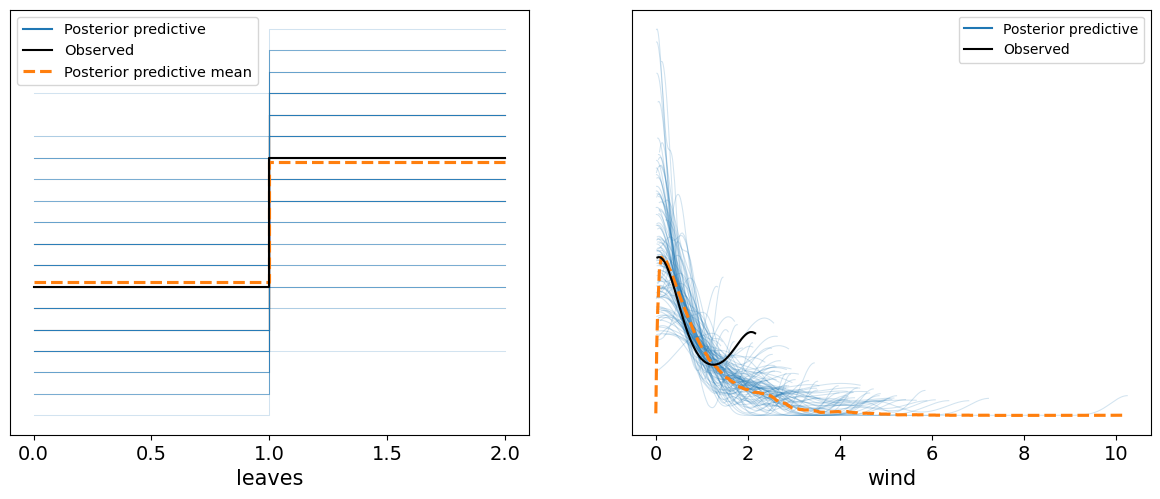

In [54]:
# sample from posterior
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=101)

az.plot_ppc(idata, num_pp_samples=100)
plt.show()

Finally, we get the correct answer! The impact of leaves on wind is 0, as expected. How did we do this? Monkeys are instruments! The monkeys show up randomly and create moving leaves. When we condition leaves on the monkeys, suddenly the impact of leaves on wind disappears. While we couldn't go outside and shake the trees without significant expense (this would have disturbed the monkeys and resulted in them attacking us) we could use our observation of monkeys to deduce the true causal relationship between leaves and wind.

Probability the leaves increase the wind: 0.498
Average impact of leaves on wind: -0.0


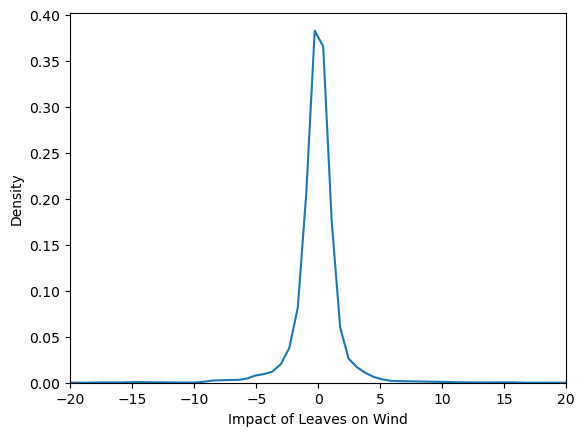

In [59]:
c = idata.posterior.c.to_numpy().flatten()
d = idata.posterior.d.to_numpy().flatten()

impact = (1 / np.exp(c + d)) - (1 / np.exp(c))
print("Probability the leaves increase the wind:", sum(impact > 0) / len(impact))
print('Average impact of leaves on wind:', impact.mean().round(1))
sns.kdeplot(impact)

plt.xlim(-20, 20)
plt.xlabel('Impact of Leaves on Wind')
plt.show()